In [1]:
import requests as rq
import lxml.html as lx
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
import math

In [2]:
#read html + make df for general stats


url = 'https://www.espn.com/nba/team/stats/_/name/sac/salary'
names = pd.read_html(url)[0]
stats = pd.read_html(url)[1]
kings_stats = pd.concat([names,stats],axis = "columns")

In [3]:
# read html + make df for shooting stats


shoot = pd.read_html(url)[3]
kings_shoot_stats = pd.concat([names,shoot], axis = "columns")

In [4]:
# clean up "name" and drop total from df


words = []
for i in kings_shoot_stats["Name"]:
    words.append(i.split()[0:2])
words = pd.DataFrame(words)
words.columns = ["First","Last"]
words["Names"] = words['First']+" "+ words["Last"]
words = words.drop("First", axis = 1).drop("Last", axis = 1)
kings_shoot_stats["Name"] = words
kings_shoot_stats = kings_shoot_stats.drop(16)

In [5]:
#create salary df
url2 = "https://www.espn.com/nba/team/roster/_/name/sac/salary"
kings_salary_raw = pd.read_html(url2)[0]

In [6]:
#Strips player number from each players name

for i in range(0,len(kings_salary_raw)):
    kings_salary_raw["Name"][i] = re.sub(r"\d+", "", str(kings_salary_raw["Name"][i]))


C:\Users\Jonathan\AppData\Local\Temp\ipykernel_4920\3064642318.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kings_salary_raw["Name"][i] = re.sub(r"\d+", "", str(kings_salary_raw["Name"][i]))


In [7]:
#Cleans dataframe to only player name + salary
kings_salary = kings_salary_raw.set_index("Name").drop('Unnamed: 0', axis = 1)
kings_salary.columns
kings_salary = kings_salary.drop(['POS', 'Age', 'HT', 'WT', 'College'], axis = 1)

In [8]:
#combine dfs. final kings 2022 df


kings_stats_22 = kings_shoot_stats.join(kings_salary, on = "Name")

In [9]:
nbateamstats = pd.DataFrame()
for i in range(2023,2018, -1):
    tempurl = "https://www.espn.com/nba/stats/team/_/view/opponent/season/"+str(i)+"/seasontype/2"
    team_names = pd.read_html(tempurl)[0]
    team_stats = pd.read_html(tempurl)[1]
    team_stats
    team_concat = pd.concat([team_names,team_stats],axis = "columns")
    team_concat['Team'] = str(i) + " " + team_concat['Team'].astype(str)
    nbateamstats = pd.concat([nbateamstats, team_concat], ignore_index = True)
nbateamstats



,RK,Team,GP,PTS,FGM,FGA,FG%,3PM,3PA,3P%,...,FTA,FT%,OR,DR,REB,AST,STL,BLK,TO,PF
0,1,2023 Dallas Mavericks,17,106.5,38.6,81.4,47.5,10.5,28.6,36.8,...,23.2,80.5,9.1,32.8,41.8,22.9,6.1,5.1,15.1,23.2
1,2,2023 Philadelphia 76ers,18,106.6,39.6,84.7,46.8,10.1,31.9,31.5,...,22.6,76.6,9.6,33.7,43.3,24.2,6.4,5.0,14.5,19.5
2,3,2023 LA Clippers,19,106.8,39.6,88.9,44.6,12.2,35.9,34.0,...,20.5,74.8,10.9,32.5,43.4,23.5,8.5,4.1,13.3,19.3
3,4,2023 Milwaukee Bucks,17,107.5,40.2,89.7,44.8,11.4,31.8,35.9,...,20.1,78.4,9.8,33.5,43.2,21.8,6.5,5.5,13.6,20.8
4,5,2023 Cleveland Cavaliers,18,107.6,38.8,85.3,45.5,11.9,32.9,36.1,...,23.2,77.5,9.3,30.2,39.4,23.8,8.4,4.4,14.3,23.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,26,2019 Sacramento Kings,82,115.3,42.3,90.6,46.6,12.0,34.6,34.8,...,24.4,77.0,11.2,36.8,48.0,24.7,7.5,5.1,15.3,21.4
146,27,2019 New Orleans Pelicans,82,116.8,43.3,92.8,46.6,12.3,33.7,36.4,...,23.5,76.4,11.0,34.8,45.8,26.5,8.6,5.4,13.1,21.0
147,28,2019 Phoenix Suns,82,116.8,42.5,88.2,48.2,11.1,29.9,37.2,...,27.6,75.3,11.8,35.3,47.2,25.9,9.0,5.0,15.2,20.7
148,29,2019 Washington Wizards,82,116.9,43.4,90.5,48.0,12.1,32.8,37.0,...,23.1,77.8,11.4,35.8,47.3,26.2,7.7,4.6,15.0,21.2


In [10]:
#nbateams = tab_dict['tab_2021']["Team"]
nbateams = pd.read_html("https://www.espn.com/nba/stats/team/_/view/opponent/season/2023/seasontype/2")[0]["Team"]

In [11]:
def clean_teams(team, stats):
    team1 = team.columns[0]
    team.columns = ["Team"]
    new_row = pd.DataFrame({team.columns[0]:team1}, index=[0])
    team = pd.concat([new_row,team.loc[:]]).reset_index(drop=True)
    for i in range(0, len(team.iloc[:,0])):
        for teamname in nbateams:
            if team.iloc[:,0][i].__contains__(teamname):
                team.iloc[:,0][i] = teamname
                break
            else:
                continue
    result = team.join(stats.iloc[:,0:2])
    return(result)
    
def add_playoff_status(df, year):
    if year == 2023:
        df["Made Playoffs"] = math.nan
        return(df)
    df["Made Playoffs"] = 0
    if year in [2019, 2020]:
        for index in df.index:
            if index < 8:
                df.iloc[index,3] = 1
    else:
        for index in df.index:
            if index < 10:
                df.iloc[index,3] = 1
    return(df)


league_wins_losses = pd.DataFrame()
for i in range(2023,2018, -1):
    urlstandings = "https://www.espn.com/nba/standings/_/season/"+ str(i)
    teams_east = pd.read_html(urlstandings)[0]
    stats_east = pd.read_html(urlstandings)[1]
    teams_west = pd.read_html(urlstandings)[2]
    stats_west = pd.read_html(urlstandings)[3]
    teams_east = clean_teams(teams_east, stats_east)
    teams_east = add_playoff_status(teams_east, i)
    teams_west = clean_teams(teams_west, stats_west)
    teams_west = add_playoff_status(teams_west, i)
    df_win_loss = pd.concat([teams_east, teams_west], ignore_index = True)
    df_win_loss['Team'] = str(i) + " " + df_win_loss['Team'].astype(str)
    league_wins_losses = pd.concat([league_wins_losses, df_win_loss], ignore_index = True)
league_wins_losses
    

,Team,W,L,Made Playoffs
0,2023 Boston Celtics,14,4,NaN
1,2023 Milwaukee Bucks,12,5,NaN
2,2023 Cleveland Cavaliers,12,6,NaN
3,2023 Atlanta Hawks,11,7,NaN
4,2023 Indiana Pacers,10,7,NaN
...,...,...,...,...
145,2019 Minnesota Timberwolves,36,46,0.0
146,2019 Memphis Grizzlies,33,49,0.0
147,2019 New Orleans Pelicans,33,49,0.0
148,2019 Dallas Mavericks,33,49,0.0


In [12]:
fullnbastats = pd.merge(league_wins_losses, nbateamstats, on="Team")
fullnbastats = fullnbastats.drop(['RK'], axis=1)
fullnbastats

,Team,W,L,Made Playoffs,GP,PTS,FGM,FGA,FG%,3PM,...,FTA,FT%,OR,DR,REB,AST,STL,BLK,TO,PF
0,2023 Boston Celtics,14,4,NaN,18,113.4,42.3,90.6,46.7,11.6,...,21.8,78.6,9.9,34.5,44.4,22.2,6.1,3.8,11.8,20.6
1,2023 Milwaukee Bucks,12,5,NaN,17,107.5,40.2,89.7,44.8,11.4,...,20.1,78.4,9.8,33.5,43.2,21.8,6.5,5.5,13.6,20.8
2,2023 Cleveland Cavaliers,12,6,NaN,18,107.6,38.8,85.3,45.5,11.9,...,23.2,77.5,9.3,30.2,39.4,23.8,8.4,4.4,14.3,23.6
3,2023 Atlanta Hawks,11,7,NaN,18,113.9,41.4,89.3,46.3,10.7,...,26.1,78.5,10.9,35.2,46.2,23.3,6.7,5.7,14.3,21.7
4,2023 Indiana Pacers,10,7,NaN,17,114.1,40.1,86.8,46.2,12.6,...,25.9,82.0,10.7,32.5,43.2,24.8,8.3,5.7,15.0,20.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2019 Minnesota Timberwolves,36,46,0.0,82,114.0,42.1,90.1,46.7,12.7,...,22.3,76.7,11.2,34.4,45.6,26.2,6.6,5.5,14.3,21.9
146,2019 Memphis Grizzlies,33,49,0.0,82,106.1,37.6,83.4,45.1,11.6,...,24.7,78.4,9.5,35.2,44.7,23.4,7.6,4.9,14.5,21.4
147,2019 New Orleans Pelicans,33,49,0.0,82,116.8,43.3,92.8,46.6,12.3,...,23.5,76.4,11.0,34.8,45.8,26.5,8.6,5.4,13.1,21.0
148,2019 Dallas Mavericks,33,49,0.0,82,110.1,40.9,89.2,45.9,11.2,...,22.0,77.7,10.2,34.6,44.8,24.5,7.8,4.5,12.5,23.2


In [13]:
nbaefficiencystats = pd.DataFrame()
for year in range(2023,2018, -1):
    efficiencyurl = "http://www.espn.com/nba/hollinger/teamstats/_/sort/defensiveEff/year/"+ str(year)
    efficiencystats = pd.read_html(efficiencyurl)[0].iloc[1: , 1:]
    efficiencystats = pd.DataFrame(efficiencystats.values[1:], columns=efficiencystats.iloc[0])
    for i in range(0, len(efficiencystats.iloc[:,0])):
        for teamname in nbateams:
            if efficiencystats.iloc[:,0][i] == "LA Lakers":
                efficiencystats.iloc[:,0][i] = "Los Angeles Lakers"
                break
            if efficiencystats.iloc[:,0][i] in teamname:
                efficiencystats.iloc[:,0][i] = teamname
                break
            else:
                continue
    efficiencystats = efficiencystats.rename(columns = {"TEAM": "Team"})
    efficiencystats['Team'] = str(year) + " " + efficiencystats['Team'].astype(str)
    efficiencystats = efficiencystats[["Team", "PACE", "EFF FG%", "OFF EFF", "DEF EFF"]]
    nbaefficiencystats = pd.concat([nbaefficiencystats, efficiencystats], ignore_index = True)
nbaefficiencystats

1,Team,PACE,EFF FG%,OFF EFF,DEF EFF
0,2023 Milwaukee Bucks,102.4,52.0,106.7,104.7
1,2023 LA Clippers,100.6,54.7,105.8,105.8
2,2023 Philadelphia 76ers,99.9,54.1,109.2,106.2
3,2023 Cleveland Cavaliers,98.6,56.0,113.6,106.3
4,2023 New Orleans Pelicans,101.8,55.4,113.8,106.6
...,...,...,...,...,...
145,2019 Chicago Bulls,101.1,50.5,102.5,110.9
146,2019 Atlanta Hawks,106.4,52.2,105.5,111.2
147,2019 Washington Wizards,103.7,53.1,108.6,111.3
148,2019 Phoenix Suns,102.9,51.4,103.6,112.2


In [14]:
fullnbastats = pd.merge(fullnbastats, nbaefficiencystats, on="Team")
fullnbastats

,Team,W,L,Made Playoffs,GP,PTS,FGM,FGA,FG%,3PM,...,REB,AST,STL,BLK,TO,PF,PACE,EFF FG%,OFF EFF,DEF EFF
0,2023 Boston Celtics,14,4,NaN,18,113.4,42.3,90.6,46.7,11.6,...,44.4,22.2,6.1,3.8,11.8,20.6,101.2,58.2,117.4,110.3
1,2023 Milwaukee Bucks,12,5,NaN,17,107.5,40.2,89.7,44.8,11.4,...,43.2,21.8,6.5,5.5,13.6,20.8,102.4,52.0,106.7,104.7
2,2023 Cleveland Cavaliers,12,6,NaN,18,107.6,38.8,85.3,45.5,11.9,...,39.4,23.8,8.4,4.4,14.3,23.6,98.6,56.0,113.6,106.3
3,2023 Atlanta Hawks,11,7,NaN,18,113.9,41.4,89.3,46.3,10.7,...,46.2,23.3,6.7,5.7,14.3,21.7,103.9,51.2,108.7,108.5
4,2023 Indiana Pacers,10,7,NaN,17,114.1,40.1,86.8,46.2,12.6,...,43.2,24.8,8.3,5.7,15.0,20.5,104.1,54.1,110.3,110.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2019 Minnesota Timberwolves,36,46,0.0,82,114.0,42.1,90.1,46.7,12.7,...,45.6,26.2,6.6,5.5,14.3,21.9,102.8,51.1,108.4,110.2
146,2019 Memphis Grizzlies,33,49,0.0,82,106.1,37.6,83.4,45.1,11.6,...,44.7,23.4,7.6,4.9,14.5,21.4,98.8,50.8,103.8,106.2
147,2019 New Orleans Pelicans,33,49,0.0,82,116.8,43.3,92.8,46.6,12.3,...,45.8,26.5,8.6,5.4,13.1,21.0,105.6,52.9,108.6,110.4
148,2019 Dallas Mavericks,33,49,0.0,82,110.1,40.9,89.2,45.9,11.2,...,44.8,24.5,7.8,4.5,12.5,23.2,101.4,51.9,106.6,108.3


In [15]:
playoffstat = fullnbastats.pop("Made Playoffs")
fullnbastats["Made Playoffs"] = playoffstat
fullnbastats

,Team,W,L,GP,PTS,FGM,FGA,FG%,3PM,3PA,...,AST,STL,BLK,TO,PF,PACE,EFF FG%,OFF EFF,DEF EFF,Made Playoffs
0,2023 Boston Celtics,14,4,18,113.4,42.3,90.6,46.7,11.6,32.1,...,22.2,6.1,3.8,11.8,20.6,101.2,58.2,117.4,110.3,NaN
1,2023 Milwaukee Bucks,12,5,17,107.5,40.2,89.7,44.8,11.4,31.8,...,21.8,6.5,5.5,13.6,20.8,102.4,52.0,106.7,104.7,NaN
2,2023 Cleveland Cavaliers,12,6,18,107.6,38.8,85.3,45.5,11.9,32.9,...,23.8,8.4,4.4,14.3,23.6,98.6,56.0,113.6,106.3,NaN
3,2023 Atlanta Hawks,11,7,18,113.9,41.4,89.3,46.3,10.7,32.3,...,23.3,6.7,5.7,14.3,21.7,103.9,51.2,108.7,108.5,NaN
4,2023 Indiana Pacers,10,7,17,114.1,40.1,86.8,46.2,12.6,33.6,...,24.8,8.3,5.7,15.0,20.5,104.1,54.1,110.3,110.7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2019 Minnesota Timberwolves,36,46,82,114.0,42.1,90.1,46.7,12.7,33.6,...,26.2,6.6,5.5,14.3,21.9,102.8,51.1,108.4,110.2,0.0
146,2019 Memphis Grizzlies,33,49,82,106.1,37.6,83.4,45.1,11.6,32.2,...,23.4,7.6,4.9,14.5,21.4,98.8,50.8,103.8,106.2,0.0
147,2019 New Orleans Pelicans,33,49,82,116.8,43.3,92.8,46.6,12.3,33.7,...,26.5,8.6,5.4,13.1,21.0,105.6,52.9,108.6,110.4,0.0
148,2019 Dallas Mavericks,33,49,82,110.1,40.9,89.2,45.9,11.2,32.5,...,24.5,7.8,4.5,12.5,23.2,101.4,51.9,106.6,108.3,0.0


In [16]:
fullnbastats["PACE"] = fullnbastats["PACE"].astype(float)
fullnbastats["EFF FG%"] = fullnbastats["EFF FG%"].astype(float)
fullnbastats["OFF EFF"] = fullnbastats["OFF EFF"].astype(float)
fullnbastats["DEF EFF"] = fullnbastats["DEF EFF"].astype(float)
kingsfullstats_5years = fullnbastats[fullnbastats['Team'].str.contains('Kings')]

#kingsx = fullnbastats.iloc[19,24]; kingsy = fullnbastats.iloc[19,25]
efficiencygraphdf = fullnbastats.iloc[:,[0,24, 25, 26]]
groups = efficiencygraphdf.groupby("Made Playoffs")
plt.figure(figsize=(10, 10))
for name, group in groups:
    if name == 0:
        name = "Did Not Make Playoffs"
        playoffcolor = 'crimson'
    else:
        name = "Made Playoffs"
        playoffcolor = 'royalblue'
    plt.plot(group["OFF EFF"], group["DEF EFF"], marker=".", linestyle="", label=name, color = playoffcolor)
plt.legend()
plt.plot('OFF EFF', 'DEF EFF', data=kingsfullstats_5years, linestyle='none', marker = 'o', color ='darkorchid')
plt.annotate('Sacramento Kings 2022-23', 
             xy=(fullnbastats.iloc[19,index1], fullnbastats.iloc[19,index2]), 
             xytext=(kingsx-2, kingsy + 1.75),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.axvline(mean(fullnbastats["OFF EFF"]), color='k', linestyle='dashed')
plt.axhline(mean(fullnbastats["DEF EFF"]), color='k', linestyle='dashed')
plt.xlabel("Offensive Efficiency (Pts Scored/100 Poss)")
plt.ylabel("Defensive Efficiency (Pts Allowed/100 Poss)")
plt.title("Offensive vs Defensive Efficiency in NBA 2018-2023")
plt.show()

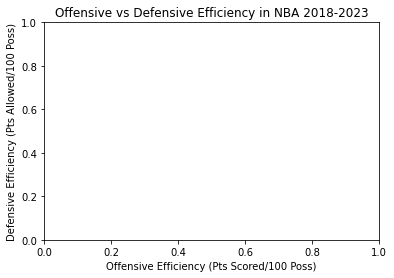

In [17]:
plt.xlabel("Offensive Efficiency (Pts Scored/100 Poss)")
plt.ylabel("Defensive Efficiency (Pts Allowed/100 Poss)")
plt.title("Offensive vs Defensive Efficiency in NBA 2018-2023")
plt.show()

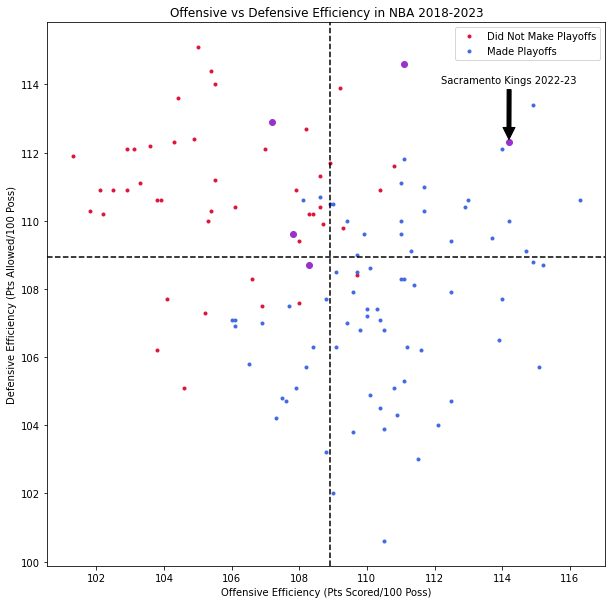

In [18]:
def comparison_plot(df, index1, index2):
    groups = df.groupby("Made Playoffs")
    plt.figure(figsize=(10, 10))
    for name, group in groups:
        if name == 0:
            name = "Did Not Make Playoffs"
            playoffcolor = 'crimson'
        else:
            name = "Made Playoffs"
            playoffcolor = 'royalblue'
        plt.plot(group.iloc[:,index1], group.iloc[:,index2], marker=".", linestyle="", label=name, color = playoffcolor)
    plt.legend()
    plt.plot(kingsfullstats_5years.iloc[:,index1], kingsfullstats_5years.iloc[:,index2], linestyle='none', marker = 'o', color ='darkorchid')
    plt.annotate('Sacramento Kings 2022-23', 
             xy=(df.iloc[19,index1], df.iloc[19,index2]), 
             xytext=(df.iloc[19,index1]-2, df.iloc[19,index2] + 1.75),
             arrowprops=dict(facecolor='black', shrink=0.05))
    plt.axvline(mean(fullnbastats.iloc[:,index1]), color='k', linestyle='dashed')
    plt.axhline(mean(fullnbastats.iloc[:,index2]), color='k', linestyle='dashed')
    
comparison_plot(fullnbastats, fullnbastats.columns.get_loc("OFF EFF"), fullnbastats.columns.get_loc("DEF EFF"))
plt.xlabel("Offensive Efficiency (Pts Scored/100 Poss)")
plt.ylabel("Defensive Efficiency (Pts Allowed/100 Poss)")
plt.title("Offensive vs Defensive Efficiency in NBA 2018-2023")
plt.show()

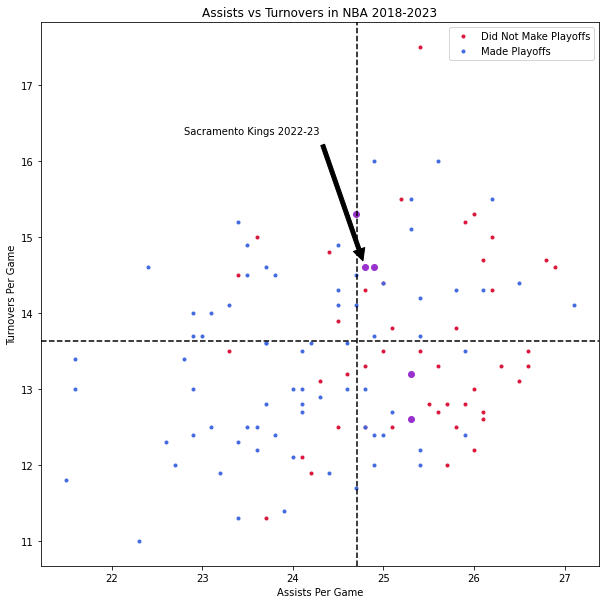

In [19]:
comparison_plot(fullnbastats, fullnbastats.columns.get_loc("AST"), fullnbastats.columns.get_loc("TO"))
plt.xlabel("Assists Per Game")
plt.ylabel("Turnovers Per Game")
plt.title("Assists vs Turnovers in NBA 2018-2023")
plt.show()

In [20]:
ast_to_graphdf = fullnbastats.iloc[:,[0,17,20,26]]
ast_to_graphdf

,Team,AST,TO,Made Playoffs
0,2023 Boston Celtics,22.2,11.8,NaN
1,2023 Milwaukee Bucks,21.8,13.6,NaN
2,2023 Cleveland Cavaliers,23.8,14.3,NaN
3,2023 Atlanta Hawks,23.3,14.3,NaN
4,2023 Indiana Pacers,24.8,15.0,NaN
...,...,...,...,...
145,2019 Minnesota Timberwolves,26.2,14.3,0.0
146,2019 Memphis Grizzlies,23.4,14.5,0.0
147,2019 New Orleans Pelicans,26.5,13.1,0.0
148,2019 Dallas Mavericks,24.5,12.5,0.0


In [21]:
#Dataframes available:
kings_stats
kings_shoot_stats
kings_salary
nbateams
kings_stats_22
league_wins_losses
nbateamstats
nbaefficiencystats
fullnbastats

,Team,W,L,GP,PTS,FGM,FGA,FG%,3PM,3PA,...,AST,STL,BLK,TO,PF,PACE,EFF FG%,OFF EFF,DEF EFF,Made Playoffs
0,2023 Boston Celtics,14,4,18,113.4,42.3,90.6,46.7,11.6,32.1,...,22.2,6.1,3.8,11.8,20.6,101.2,58.2,117.4,110.3,NaN
1,2023 Milwaukee Bucks,12,5,17,107.5,40.2,89.7,44.8,11.4,31.8,...,21.8,6.5,5.5,13.6,20.8,102.4,52.0,106.7,104.7,NaN
2,2023 Cleveland Cavaliers,12,6,18,107.6,38.8,85.3,45.5,11.9,32.9,...,23.8,8.4,4.4,14.3,23.6,98.6,56.0,113.6,106.3,NaN
3,2023 Atlanta Hawks,11,7,18,113.9,41.4,89.3,46.3,10.7,32.3,...,23.3,6.7,5.7,14.3,21.7,103.9,51.2,108.7,108.5,NaN
4,2023 Indiana Pacers,10,7,17,114.1,40.1,86.8,46.2,12.6,33.6,...,24.8,8.3,5.7,15.0,20.5,104.1,54.1,110.3,110.7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2019 Minnesota Timberwolves,36,46,82,114.0,42.1,90.1,46.7,12.7,33.6,...,26.2,6.6,5.5,14.3,21.9,102.8,51.1,108.4,110.2,0.0
146,2019 Memphis Grizzlies,33,49,82,106.1,37.6,83.4,45.1,11.6,32.2,...,23.4,7.6,4.9,14.5,21.4,98.8,50.8,103.8,106.2,0.0
147,2019 New Orleans Pelicans,33,49,82,116.8,43.3,92.8,46.6,12.3,33.7,...,26.5,8.6,5.4,13.1,21.0,105.6,52.9,108.6,110.4,0.0
148,2019 Dallas Mavericks,33,49,82,110.1,40.9,89.2,45.9,11.2,32.5,...,24.5,7.8,4.5,12.5,23.2,101.4,51.9,106.6,108.3,0.0
